Kaggle Competition On-going Project : LLM Classification Finetuning

Group Members:
1.   Pratiksha
2.   Jeevan
3.   Nikhitha

Problem Statement:

The goal of this project is to predict human preferences between responses from two large language models (LLMs). The dataset comes from the ChatBot Arena, where judges are given a prompt and responses from two different models. They then select the better response - or mark it as a tie.

Each example gives you:

A prompt (the question)

Two responses (from different language models)

The judge picks the better response — or says it’s a tie.
Your job is to predict the judge’s choice based on the prompt and both responses.

Dataset Features:

1. id: Unique identifier for each example
2. model_a, model_b: Names of the two compared models
3. Prompt: The question or input given to both models
4. response_a, response_b: Responses generated by model A and model B
5. winner_model_a, winner_model_b, winner_model_tie: 6. Target columns showing the judge's choice (only one is marked as 1) winner_model_a, winner_model_b, tie


Steps followed for the project:

1. Data Collection
2. Data preprocessing(Missing values,encoding)
3. spliting the data into train,validation and test
4. Model selection, training and hypertuning,predicing
5. Additionally used cosine similarity and Lime functions

Dataset has around 57477 samples & 9 features initially

Import required libraries

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

Load the Dataset & Get parameters

In [ ]:
# load the data into dataframe
df = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#display the first few rows
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [ ]:
#get the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [ ]:
#check for null values if any
df.isnull().sum()

,0
id,0
model_a,0
model_b,0
prompt,0
response_a,0
response_b,0
winner_model_a,0
winner_model_b,0
winner_tie,0


In [ ]:
#get shape
df.shape

(57477, 9)

# Preprocessing

In [ ]:
#The label is already processed with one-hot encoding
# Define a function to map the one-hot to a label
def decode_winner(row):
    if row['winner_model_a'] == 1:
        return 'model_a'
    elif row['winner_model_b'] == 1:
        return 'model_b'
    elif row['winner_tie'] == 1:
        return 'tie'
    else:
        return 'unknown'  # optional fallback if any

# Apply the function for every row
df['winner_id'] = df.apply(decode_winner, axis=1)

In [ ]:
#as the values are converted in the form of lables further used label encoder to map to numeric values

le = LabelEncoder()
df['winner_id_encoded'] = le.fit_transform(df['winner_id'])

mapping = {label: int(code) for label, code in zip(le.classes_, le.transform(le.classes_))}
print(mapping)

{'model_a': 0, 'model_b': 1, 'tie': 2}


In [ ]:
#drop the columns and make one winner column which is encoded
df = df.drop(columns=['winner_model_a', 'winner_model_b', 'winner_tie', 'winner_id'])

In [ ]:
#display few rows to crosscheck
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_id_encoded
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",1
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",2
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",1


# Text Cleaning and pairing of prompt+response

In [ ]:
#as every LLM model like chatgpt expects the text in the form of string so every text is precedeed with [] brackets
#so remove them  from prompt, response_a, response_b
#further combining the prompt and both responses helps the model predict which response is preferred by the judge.

import re

def clean_text(x):
    """
    This function removes unwanted characters like brackets and quotes from a string.
    """
    # Remove any leading or trailing spaces
    x = x.strip()
    # Remove the surrounding brackets and quotes if present
    x = re.sub(r'^\[\"(.*)\"\]$', r'\1', x)  # Remove ["] and "] around the text
    return x

# Apply the cleaning function to each column individually
df['prompt'] = df['prompt'].apply(clean_text)
df['response_a'] = df['response_a'].apply(clean_text)
df['response_b'] = df['response_b'].apply(clean_text)

# Combine prompt with response_a and response_b for model input
df['input_a'] = df['prompt'] + " " + df['response_a']
df['input_b'] = df['prompt'] + " " + df['response_b']

In [ ]:
#displayed rows after pre-processing
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_id_encoded,input_a,input_b
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",0,Is it morally right to try to have a certain p...,Is it morally right to try to have a certain p...
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,1,What is the difference between marriage licens...,What is the difference between marriage licens...
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,2,explain function calling. how would you call a...,explain function calling. how would you call a...
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,0,How can I create a test set for a very rare ca...,How can I create a test set for a very rare ca...
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,1,What is the best way to travel from Tel-Aviv t...,What is the best way to travel from Tel-Aviv t...


In [ ]:
 #Drop the original columns as don't need them anymore
df.drop(['prompt', 'response_a', 'response_b'], axis=1, inplace=True)

# Now df only contains the combined input columns and other necessary information
df.head()

,id,model_a,model_b,winner_id_encoded,input_a,input_b
0,30192,gpt-4-1106-preview,gpt-4-0613,0,Is it morally right to try to have a certain p...,Is it morally right to try to have a certain p...
1,53567,koala-13b,gpt-4-0613,1,What is the difference between marriage licens...,What is the difference between marriage licens...
2,65089,gpt-3.5-turbo-0613,mistral-medium,2,explain function calling. how would you call a...,explain function calling. how would you call a...
3,96401,llama-2-13b-chat,mistral-7b-instruct,0,How can I create a test set for a very rare ca...,How can I create a test set for a very rare ca...
4,198779,koala-13b,gpt-3.5-turbo-0314,1,What is the best way to travel from Tel-Aviv t...,What is the best way to travel from Tel-Aviv t...


In [ ]:
#checking the proportion of label categories to know if there is any imbalance
df['winner_id_encoded'].value_counts(normalize=True)

,proportion
winner_id_encoded,
0,0.349079
1,0.341911
2,0.309011


In [ ]:
import pickle

file_path = '/content/drive/MyDrive/Colab Notebooks/Embeddings (1).pkl'  # adjust path as needed

with open(file_path, 'rb') as f:
    embeddings_data = pickle.load(f)


In [ ]:
# Access the individual parts
embeddings_a = embeddings_data['embeddings_a']
embeddings_b = embeddings_data['embeddings_b']
embeddings_prompt = embeddings_data['embeddings_prompt']

print("Embeddings loaded successfully!")
print("Shape of embeddings_a:", len(embeddings_a))
print("Shape of embeddings_b:", len(embeddings_b))
print("Shape of embeddings_prompt:", len(embeddings_prompt))

# Train-Validation-Test split

In [ ]:
# Step 1: Split the data into training and test sets (80% training, 20% testing)
X = df[['input_a', 'input_b']]  # Features (text columns)
y = df['winner_id_encoded']  # Target (winner label)

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, stratify=y, test_size=0.2, random_state=42)

# Step 2: Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#checking the proportion
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(y_train))
print(len(y_val))
print(len(y_test))

36784
9197
11496
36784
9197
11496


Embeddings: To convert text to vectors, install sentence-transformers to get embeddings

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 750.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Get embeddings from sentence transformer models from huggingface and we used 'all-MiniLM-L6-v2' and get them in batches as it is huge data and taking time to get the embeddings so save accordingly as colab might get inactive after some time-out

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from multiprocessing import Pool
import os
from tqdm import tqdm
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the model once (not inside pool)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode helper
def encode_batch(texts):
    return model.encode(texts, show_progress_bar=False)

# Safe batch-wise encoder with resume
def encode_data_in_batches(X, output_prefix, batch_size=500):
    input_a_batches = np.array_split(X[:, 0], len(X) // batch_size + 1)
    input_b_batches = np.array_split(X[:, 1], len(X) // batch_size + 1)

    input_a_all, input_b_all = [], []
    save_dir = f'/content/drive/MyDrive/embeddings/{output_prefix}'
    os.makedirs(save_dir, exist_ok=True)

    for i in tqdm(range(len(input_a_batches)), desc=f"Encoding {output_prefix}"):
        a_path = f'{save_dir}/input_a_batch_{i}.npy'
        b_path = f'{save_dir}/input_b_batch_{i}.npy'

        if os.path.exists(a_path) and os.path.exists(b_path):
            input_a = np.load(a_path)
            input_b = np.load(b_path)
        else:
            input_a = encode_batch(input_a_batches[i])
            input_b = encode_batch(input_b_batches[i])
            np.save(a_path, input_a)
            np.save(b_path, input_b)

        input_a_all.append(input_a)
        input_b_all.append(input_b)

    return np.concatenate(input_a_all), np.concatenate(input_b_all)


X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

# Process each split
train_a, train_b = encode_data_in_batches(X_train, 'train')
val_a, val_b = encode_data_in_batches(X_val, 'val')
test_a, test_b = encode_data_in_batches(X_test, 'test')

# Save final full embeddings
np.save('/content/drive/MyDrive/embeddings/train_input_a.npy', train_a)
np.save('/content/drive/MyDrive/embeddings/train_input_b.npy', train_b)

np.save('/content/drive/MyDrive/embeddings/val_input_a.npy', val_a)
np.save('/content/drive/MyDrive/embeddings/val_input_b.npy', val_b)

np.save('/content/drive/MyDrive/embeddings/test_input_a.npy', test_a)
np.save('/content/drive/MyDrive/embeddings/test_input_b.npy', test_b)

print("✅ All embeddings saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Encoding test: 100%|██████████| 23/23 [51:10<00:00, 133.51s/it]


✅ All embeddings saved successfully!


In [7]:
#load the data from the files as we have two responses so got embeddings seperately for each column
#in two seperate files

train_a = np.load('/content/drive/MyDrive/embeddings/train_input_a.npy')
train_b = np.load('/content/drive/MyDrive/embeddings/train_input_b.npy')

val_a = np.load('/content/drive/MyDrive/embeddings/val_input_a.npy')
val_b = np.load('/content/drive/MyDrive/embeddings/val_input_b.npy')

test_a = np.load('/content/drive/MyDrive/embeddings/test_input_a.npy')
test_b = np.load('/content/drive/MyDrive/embeddings/test_input_b.npy')



Cosine Similarity data distribution

In [10]:
import numpy as np

def fast_cosine_similarity(a, b):
    # Normalize both embeddings
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)

    # Compute row-wise dot product (equivalent to cosine similarity for normalized vectors)
    return np.einsum('ij,ij->i', a_norm, b_norm)

In [11]:
#check the cosine similarity
cos_sim_train_a_b = fast_cosine_similarity(train_a, train_b)

In [ ]:
print(min(cos_sim_train_a_b))
print(max(cos_sim_train_a_b))

-0.04629273
1.0000004


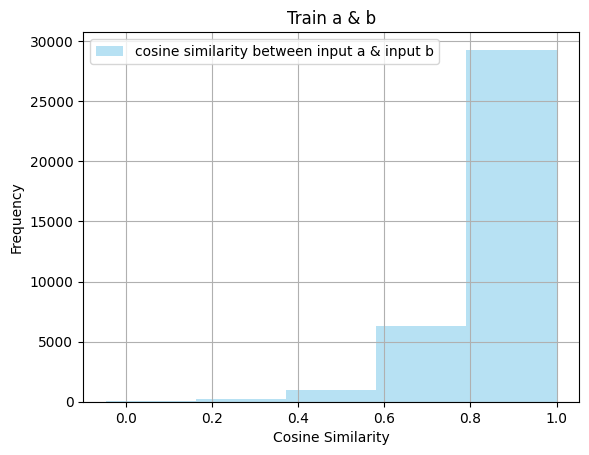

In [12]:
#plot the similarity
plt.hist(cos_sim_train_a_b, bins=5, alpha=0.6, label='cosine similarity between input a & input b', color='skyblue')
plt.title("Train a & b")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

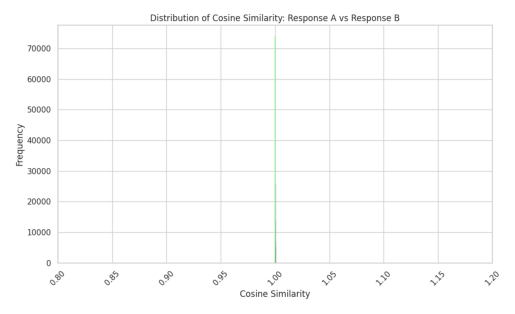

In [2]:
from PIL import Image

# Path to image in your Google Drive
img_path = '/content/drive/MyDrive/response_a_b.png'

# Open and display
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

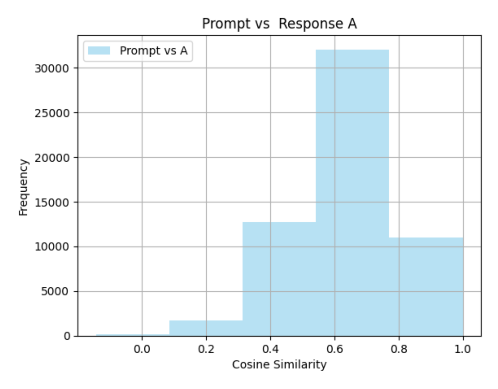

In [3]:
from PIL import Image

# Path to image in your Google Drive
img_path = '/content/drive/MyDrive/prompt_response_a.png'

# Open and display
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

cos_sim_a_b = 0.99999964, 1.0000005

cos_sim_prompt_b = -0.14217162 1.0000002

cos_sim_prompt_a = -0.14217162 1.0000002


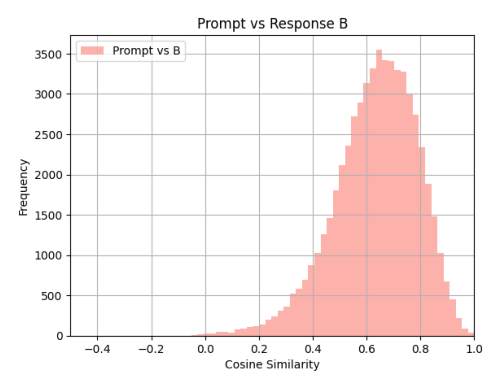

In [4]:
from PIL import Image

# Path to image in your Google Drive
img_path = '/content/drive/MyDrive/prompt_response_b.png'

# Open and display
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


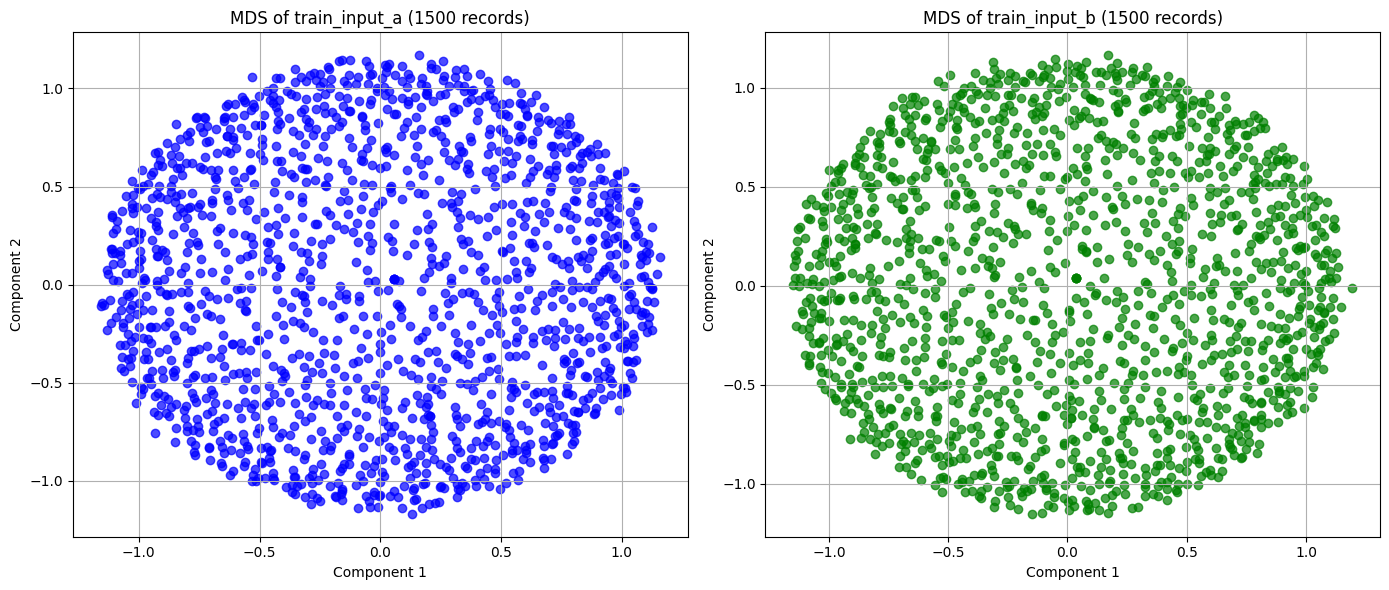

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Select only 3000 records from train_a and train_b
train_a_1500 = train_a[:1500]
train_b_1500 = train_b[:1500]

# Initialize MDS model
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42)

# Run MDS on the selected 500 records from each embedding set
train_a_mds = mds.fit_transform(train_a_1500)
train_b_mds = mds.fit_transform(train_b_1500)

# Plot both side-by-side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_a_mds[:, 0], train_a_mds[:, 1], alpha=0.7, c='blue')
plt.title("MDS of train_input_a (1500 records)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(train_b_mds[:, 0], train_b_mds[:, 1], alpha=0.7, c='green')
plt.title("MDS of train_input_b (1500 records)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)

plt.tight_layout()
plt.show()

Modeling:
Used Logistic Regression for multi-class classification
Created pipeline with scaling and model
Used Cross Vadlidation K-Folds on training data and used Learning Curves
Performed prediction on Validation data and displayed classification report and accuracy

Cross-Validation Scores on Training Set: [0.41333188 0.42116137 0.41670291 0.4222488 ]
Average CV Accuracy: 0.41836124401913877

Validation Performance:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46      3177
           1       0.41      0.45      0.43      3179
           2       0.40      0.32      0.36      2841

    accuracy                           0.42      9197
   macro avg       0.42      0.42      0.42      9197
weighted avg       0.42      0.42      0.42      9197

Validation Accuracy: 0.422311623355442


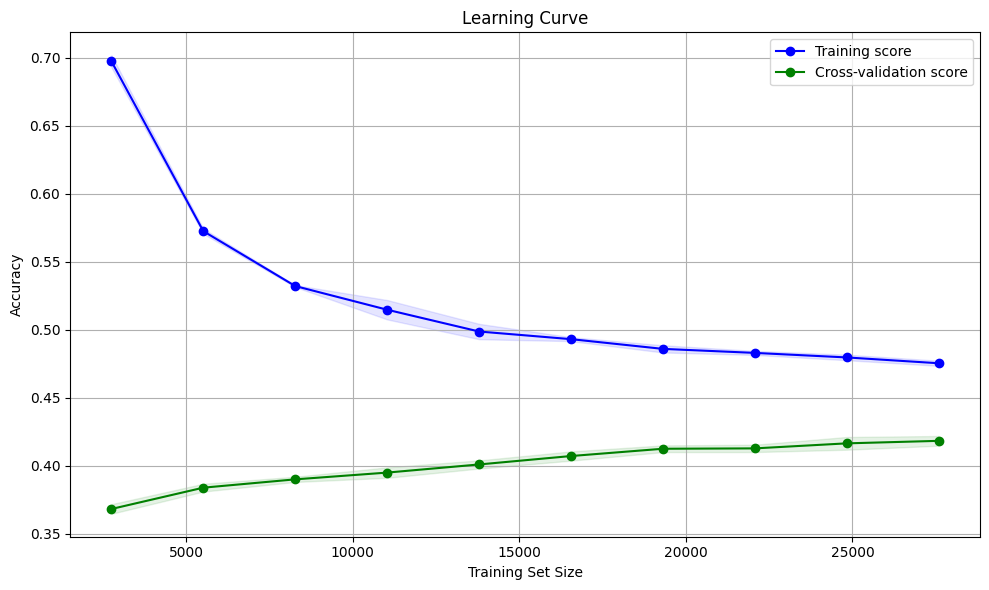

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Combine embeddings for training and validation data
X_train = np.column_stack((train_a, train_b))
X_val = np.column_stack((val_a, val_b))

# Create a pipeline with scaling and logistic regression
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='lbfgs',max_iter=500,random_state=42))

# Perform cross-validation on the training set
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='accuracy')
print("Cross-Validation Scores on Training Set:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

# Fit the model on the full training data
pipeline.fit(X_train, y_train)

# Predict on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

Insight: As its tending to overfit and the performance is not that good so used techniques to improve the model performance first started with dimension reduction to deal with overfitting using UMap used no of components as 2

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


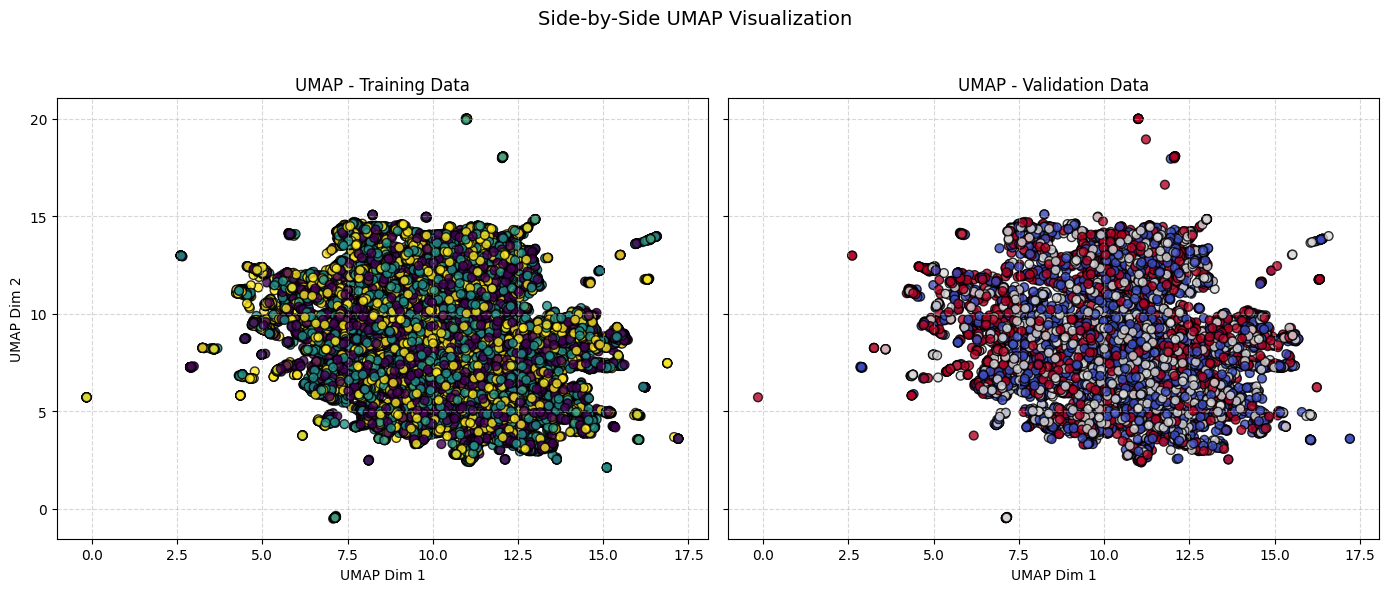

In [ ]:
import umap
reducer = umap.UMAP(n_components=2, random_state=42)
X_train_umap = reducer.fit_transform(X_train)
X_val_umap = reducer.transform(X_val)  # Works like PCA

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Training Data Plot
scatter1 = axs[0].scatter(X_train_umap[:, 0], X_train_umap[:, 1],
                          c=y_train, cmap='viridis', s=40, alpha=0.8, edgecolors='k')
axs[0].set_title("UMAP - Training Data")
axs[0].set_xlabel("UMAP Dim 1")
axs[0].set_ylabel("UMAP Dim 2")
axs[0].grid(True, linestyle='--', alpha=0.5)

# Validation Data Plot
scatter2 = axs[1].scatter(X_val_umap[:, 0], X_val_umap[:, 1],
                          c=y_val, cmap='coolwarm', s=40, alpha=0.8, edgecolors='k')
axs[1].set_title("UMAP - Validation Data")
axs[1].set_xlabel("UMAP Dim 1")
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Side-by-Side UMAP Visualization", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Further using PCA columns and hyperparameter tuing(C, max_iter) using RandomizedSearchCV got the best parameters and further predicting on validation data using best parameters obtained

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42)
)

# Define the hyperparameters to sample (for RandomizedSearchCV)
param_dist = {
    'logisticregression__solver': ['lbfgs'],
    'logisticregression__C': np.logspace(-2, 2, 10),  # Values from 0.001 to 1000
    'logisticregression__max_iter': [300, 500, 1000]
}

# Randomized search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=4, n_iter=25, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_umap, y_train)

# Best Parameters and CV Accuracy
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# Predict on validation set using the best model from the randomized search
y_val_pred = random_search.best_estimator_.predict(X_val_umap)
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Best Parameters: {'logisticregression__solver': 'lbfgs', 'logisticregression__max_iter': 300, 'logisticregression__C': np.float64(0.01)}
Best CV Accuracy: 0.3617333623314485

Validation Performance:
              precision    recall  f1-score   support

           0       0.35      0.88      0.51      3177
           1       0.23      0.00      0.00      3179
           2       0.41      0.19      0.26      2841

    accuracy                           0.36      9197
   macro avg       0.33      0.36      0.26      9197
weighted avg       0.33      0.36      0.26      9197

Validation Accuracy: 0.36316190061976733


Insight: The Model performance is even worse using Dimension reduction as there is a loss of information so further used actual features instead of pca and hyperparameters to improve the performance and used learning curves to interpret and further predicted on test data and displayed classification report, confusion matrix and ROC curve

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42)
)

# Define the hyperparameters to sample (for RandomizedSearchCV)
param_dist = {
    'logisticregression__solver': ['lbfgs'],
    'logisticregression__C': np.logspace(-2, 2, 10),  # Values from 0.001 to 1000
    'logisticregression__max_iter': [300, 500, 1000]
}

# Randomized search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=4, n_iter=25, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best Parameters and CV Accuracy
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# Predict on validation set using the best model from the randomized search
y_val_pred = random_search.best_estimator_.predict(X_val)
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

Best Parameters: {'logisticregression__solver': 'lbfgs', 'logisticregression__max_iter': 300, 'logisticregression__C': np.float64(0.01)}
Best CV Accuracy: 0.4220313179643323

Validation Performance:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46      3177
           1       0.42      0.45      0.43      3179
           2       0.40      0.31      0.35      2841

    accuracy                           0.42      9197
   macro avg       0.42      0.42      0.42      9197
weighted avg       0.42      0.42      0.42      9197

Validation Accuracy: 0.42057192562792217


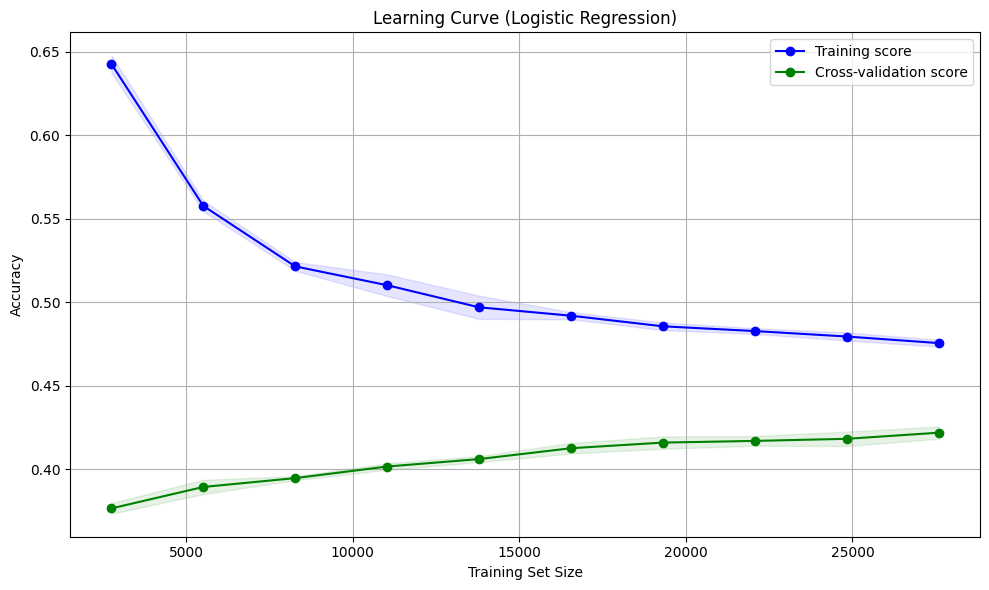

In [ ]:
# Plot learning curve with the best model from RandomizedSearchCV
train_sizes, train_scores, val_scores = learning_curve(
    estimator=random_search.best_estimator_,
    X=X_train,
    y=y_train,
    cv=4,  # 4-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Assuming the test data has two features like the validation data
X_test = np.column_stack((test_a, test_b))  # Combine test data features

# Predict on the test data using the best estimator from GridSearchCV
y_test_pred = random_search.best_estimator_.predict(X_test) # Use predict on best_estimator_

# Print classification report and accuracy for test data
print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))



Test Performance:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46      4013
           1       0.44      0.47      0.45      3931
           2       0.40      0.32      0.35      3552

    accuracy                           0.43     11496
   macro avg       0.43      0.43      0.42     11496
weighted avg       0.43      0.43      0.43     11496

Test Accuracy: 0.42945372303409884


Confusion Matrix on Test

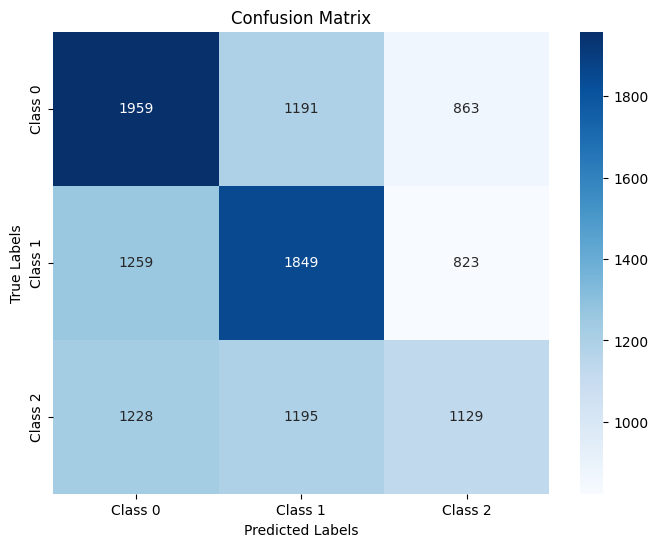

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ROC curve for TPR & FPR

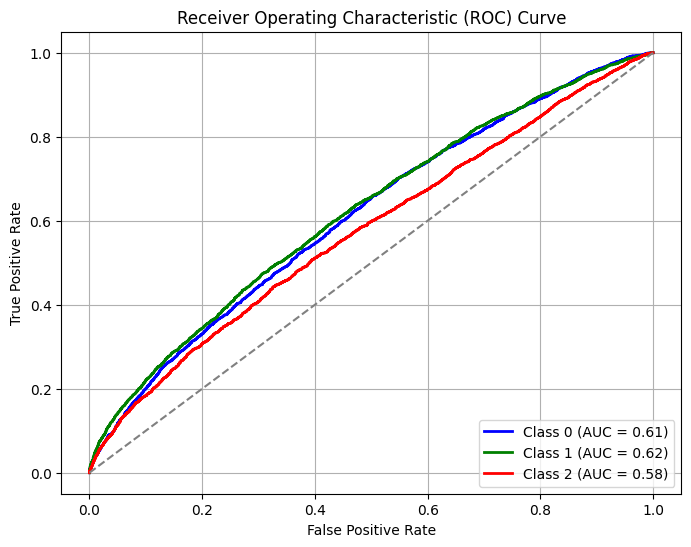

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for each class
y_test_prob = random_search.best_estimator_.predict_proba(X_test)

# Compute the ROC curve for each class
fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 0], pos_label=0)  # For Class 0
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Class 0 (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1], pos_label=1)  # For Class 1
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label=f'Class 1 (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 2], pos_label=2)  # For Class 2
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'Class 2 (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Checked cosine similarity and used lime for explainability

Cosine Similarity for Train Data (First 3 samples):
[[0.9206457  0.01265239 0.27868444]
 [0.01518188 0.85020673 0.12635018]
 [0.27705094 0.00458651 0.92683184]]


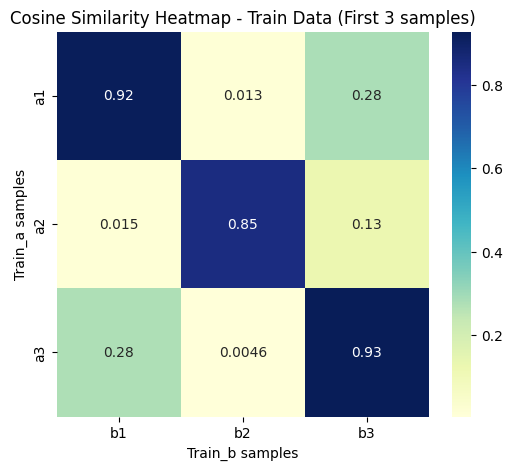

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

train_a_3 = train_a[:3]  # First 3 samples from train_a
train_b_3 = train_b[:3]  # First 3 samples from train_b

# --- Compute Cosine Similarity ---
# Compute cosine similarity between the first 3 samples of train_a and train_b
train_cos_sim = cosine_similarity(train_a_3, train_b_3)

# --- Print Cosine Similarity Matrix ---
print("Cosine Similarity for Train Data (First 3 samples):")
print(train_cos_sim)

# --- Visualizing Cosine Similarity Using Heatmap ---

# Visualize the cosine similarity for the first 3 rows of train_a and train_b
plt.figure(figsize=(6, 5))
sns.heatmap(train_cos_sim, annot=True, cmap="YlGnBu", xticklabels=[f"b{i+1}" for i in range(train_b_3.shape[0])],
            yticklabels=[f"a{i+1}" for i in range(train_a_3.shape[0])])
plt.title("Cosine Similarity Heatmap - Train Data (First 3 samples)")
plt.xlabel("Train_b samples")
plt.ylabel("Train_a samples")
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=933448b927d0ea1fc38bcdd12182f94ec7486d7be402fa038b0ade2954b26196
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
#using lime for one instance
print(y_test_pred[1])

1


Predicted Class: model_b
Prediction Probabilities: [0.28998997 0.36870309 0.34130694]

Explanation for predicted class:
Embedding Dimension 127 > 0.00: -0.0509
Embedding Dimension 322 > 0.04: 0.0474
Embedding Dimension 623 <= -0.04: 0.0472
Embedding Dimension 426 <= -0.03: 0.0464
Embedding Dimension 456 <= -0.05: -0.0411
Embedding Dimension 746 <= -0.05: 0.0401
Embedding Dimension 706 > 0.04: -0.0369
Embedding Dimension 276 <= -0.05: 0.0337
Embedding Dimension 357 > 0.02: 0.0310
Embedding Dimension 72 <= -0.05: 0.0279


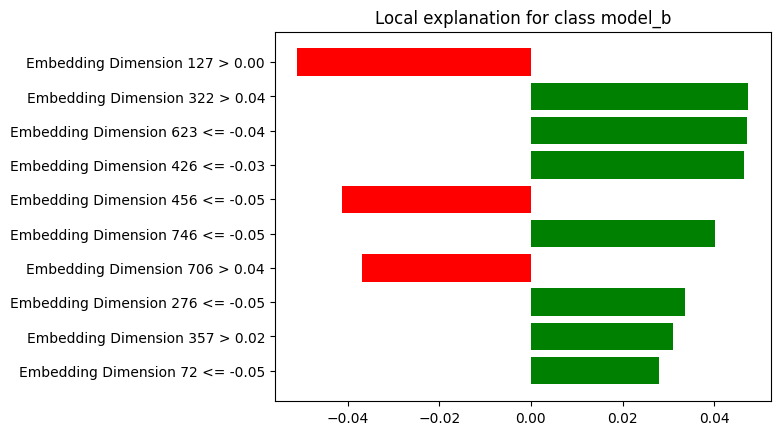

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Pick a test instance to explain
instance_to_explain = X_test[1]

# Set up the LIME explainer for embeddings
explainer = LimeTabularExplainer(
    training_data=X_train,
    training_labels=y_train,
    mode='classification',
    feature_names=[f'Embedding Dimension {i}' for i in range(X_train.shape[1])],
    class_names=['model_a', 'model_b', 'tie'],
    discretize_continuous=True
)

# Generate explanation, making sure all class labels are included
explanation = explainer.explain_instance(
    instance_to_explain,
    random_search.best_estimator_.predict_proba,
    labels=[0, 1, 2]
)

# Find predicted class (index of highest probability)
predicted_class = np.argmax(explanation.predict_proba)  # Use [0] to access the probabilities for this instance
predicted_class_name = explainer.class_names[predicted_class]

# Print the predicted class and prediction probabilities for all classes
print(f"Predicted Class: {predicted_class_name}")
print("Prediction Probabilities:", explanation.predict_proba)

# Print the explanation for the predicted class
print("\nExplanation for predicted class:")
for feature, importance in explanation.as_list(label=predicted_class):
    print(f"{feature}: {importance:.4f}")

# Visualize the explanation (only works in Colab/Jupyter)
%matplotlib inline
fig = explanation.as_pyplot_figure(label=predicted_class)
fig.show()

Modelling: Used Random forest model and trained on train data and used crossvalidation for better learning and predicted on validation data and used learning curves

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=4, scoring='accuracy')
print("Cross-Validation Scores on Training Set:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))

# Fit the model on the full training data
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Print validation performance
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Cross-Validation Scores on Training Set: [0.38940844 0.38875598 0.38375381 0.38408003]
Average CV Accuracy: 0.38649956502827315

Validation Performance:
              precision    recall  f1-score   support

           0       0.38      0.49      0.43      3177
           1       0.38      0.40      0.39      3179
           2       0.42      0.28      0.34      2841

    accuracy                           0.39      9197
   macro avg       0.40      0.39      0.39      9197
weighted avg       0.40      0.39      0.39      9197

Validation Accuracy: 0.39175818201587476


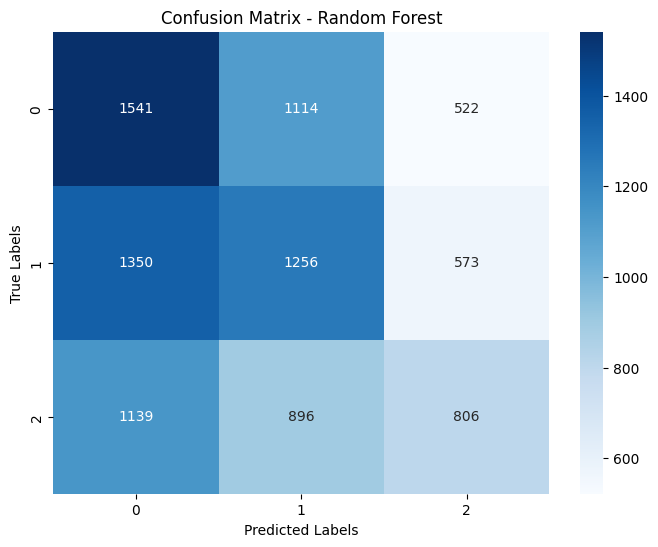

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Insight: Model is not perfporming well so used hyperparameter tuning on max_depth, max_features and used RandomizedSearchCV to find best parameters and trained on train and predicted on validation and test data

In [ ]:
from scipy.stats import randint

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_samples=0.3
)

# hyperparameter ranges (faster convergence)
param_dist = {
    'n_estimators': randint(30, 100),  # smaller range
    'max_depth': randint(5, 15),
    'min_samples_split': randint(10, 20),
    'min_samples_leaf': randint(20, 30),
    'max_features': ['sqrt'],  # fixed to 1 value
    'bootstrap': [True]
}

# Use iterations & folds
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Try just 3 combinations
    cv=3,  # Only 2-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Evaluate best model
best_rf_model = random_search.best_estimator_
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=3, scoring='accuracy')
print("Best Hyperparameters:", random_search.best_params_)
print("CV Scores:", cv_scores)
print("Avg CV Accuracy:", np.mean(cv_scores))

# Fit full model and evaluate
best_rf_model.fit(X_train, y_train)
y_val_pred = best_rf_model.predict(X_val)

print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

Best Hyperparameters: {'bootstrap': True, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 25, 'min_samples_split': 11, 'n_estimators': 93}
CV Scores: [0.39650954 0.38895686 0.38863062]
Avg CV Accuracy: 0.3913656713823866

Validation Performance:
              precision    recall  f1-score   support

           0       0.39      0.59      0.47      3177
           1       0.40      0.38      0.39      3179
           2       0.46      0.22      0.30      2841

    accuracy                           0.40      9197
   macro avg       0.42      0.40      0.39      9197
weighted avg       0.41      0.40      0.39      9197

Validation Accuracy: 0.4035011416766337


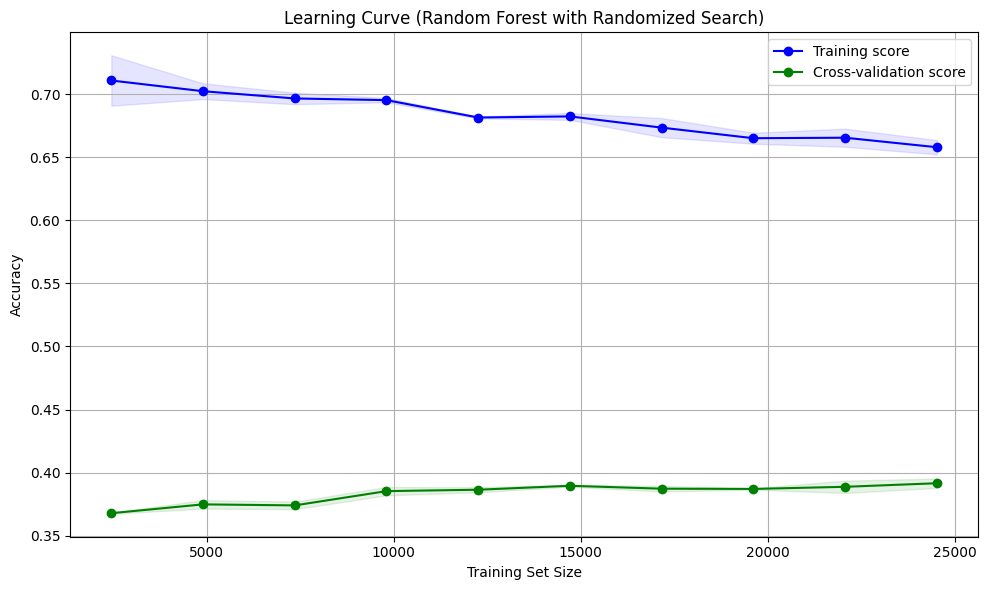

In [ ]:
# Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_rf_model,
    X=X_train,
    y=y_train,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title("Learning Curve (Random Forest with Randomized Search)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Predict on the test data using the best estimator from GridSearchCV
y_test_pred = random_search.best_estimator_.predict(X_test)

# Print classification report and accuracy for test data
print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))



Test Performance:
              precision    recall  f1-score   support

           0       0.35      0.77      0.48      4013
           1       0.35      0.24      0.29      3931
           2       0.00      0.00      0.00      3552

    accuracy                           0.35     11496
   macro avg       0.23      0.34      0.26     11496
weighted avg       0.24      0.35      0.27     11496

Test Accuracy: 0.35116562282533054


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

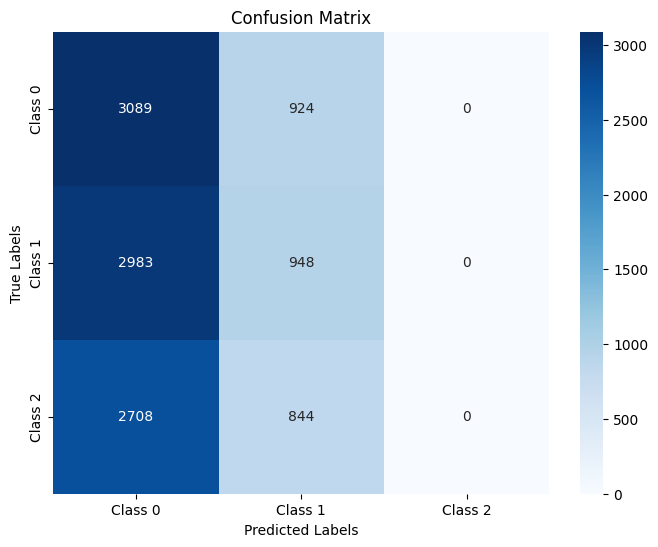

In [ ]:
# Confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ROC Curve

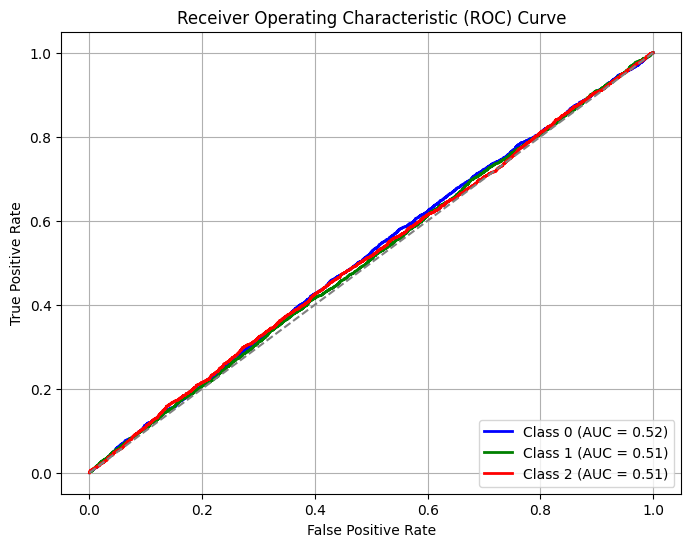

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
y_test_prob = random_search.best_estimator_.predict_proba(X_test)

# Compute the ROC curve for each class
fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 0], pos_label=0)  # For Class 0
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Class 0 (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1], pos_label=1)  # For Class 1
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label=f'Class 1 (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 2], pos_label=2)  # For Class 2
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'Class 2 (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Modelling used Neural Network Modelling used relu and softmax activation function

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3331 - loss: 1.3808 - val_accuracy: 0.3860 - val_loss: 1.0876 - learning_rate: 0.0010
Epoch 2/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3817 - loss: 1.0999 - val_accuracy: 0.4028 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 3/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4095 - loss: 1.0790 - val_accuracy: 0.4152 - val_loss: 1.0709 - learning_rate: 0.0010
Epoch 4/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4285 - loss: 1.0643 - val_accuracy: 0.4251 - val_loss: 1.0614 - learning_rate: 0.0010
Epoch 5/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4506 - loss: 1.0501 - val_accuracy: 0.4296 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 6/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4531 - loss: 1.0436 - val_accuracy: 0.4194 - val_loss: 1.0620 - learning_rate: 0.0010
Epoch 7/100
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4655 -

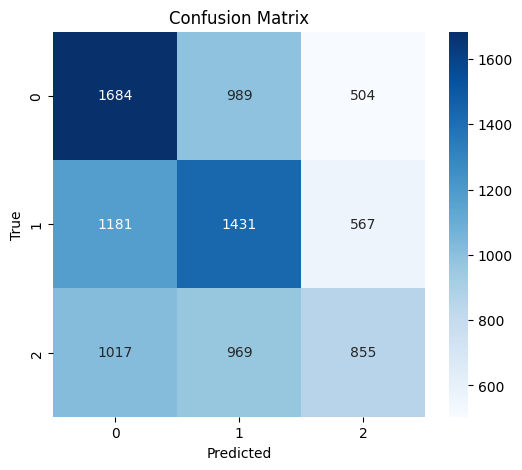

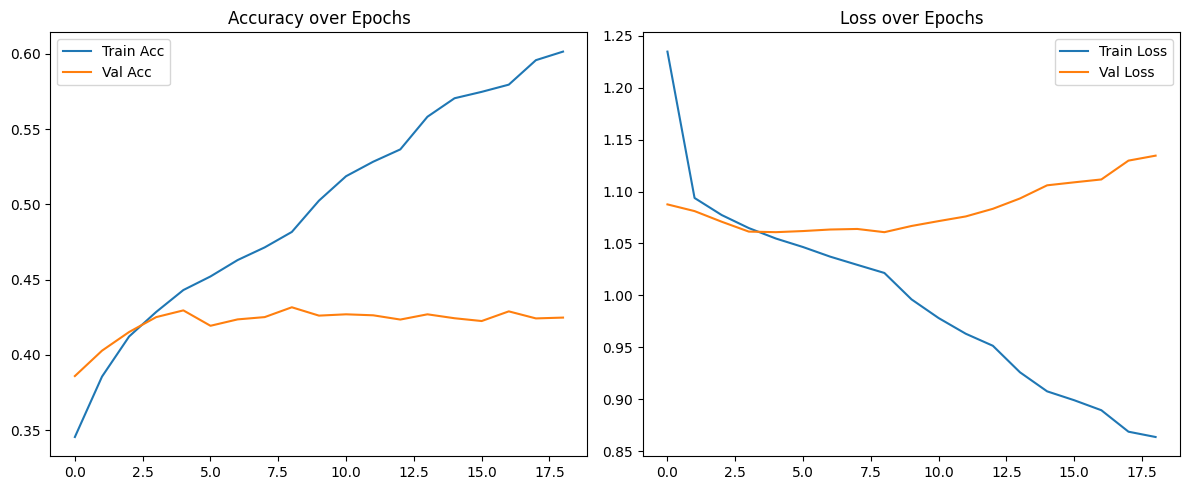

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#modelling
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

#outer layer
model.add(Dense(3, activation='softmax'))  #output classes=3

#Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Smart Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

# Train using epochs
history = model.fit(
    X_train, y_train,
    epochs=100,                # more epochs for deeper net
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predict & Evaluate
y_val_pred = model.predict(X_val)
y_val_pred_class = np.argmax(y_val_pred, axis=1)

print("\n Classification Report:")
print(classification_report(y_val, y_val_pred_class))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_class))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_val_pred_class), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy & Loss Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict probabilities
y_test_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Print classification report and accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52      4013
           1       0.00      0.00      0.00      3931
           2       0.00      0.00      0.00      3552

    accuracy                           0.35     11496
   macro avg       0.12      0.33      0.17     11496
weighted avg       0.12      0.35      0.18     11496

Testing Accuracy: 0.34907794015309673


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

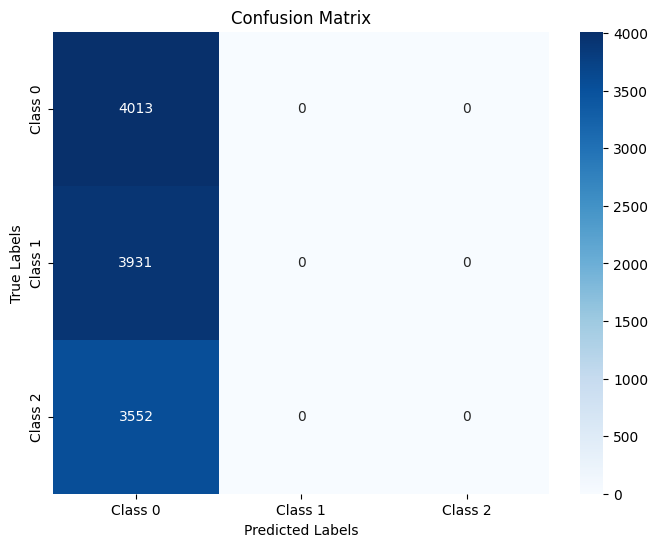

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ROC Curve

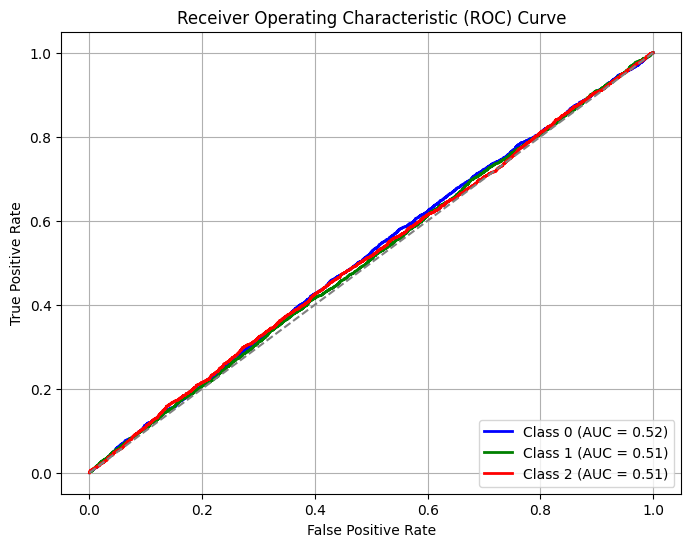

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
y_test_prob = random_search.best_estimator_.predict_proba(X_test)

# Compute the ROC curve for each class
fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 0], pos_label=0)  # For Class 0
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Class 0 (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1], pos_label=1)  # For Class 1
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label=f'Class 1 (AUC = {roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 2], pos_label=2)  # For Class 2
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'Class 2 (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Challenges
Large Embedding Files: Loading high-dimensional .npy embeddings (input_a and input_b) caused significant I/O and memory bottlenecks, especially when accessed from cloud storage.

Compute Overhead: Managing large data volumes strained memory and slowed down model training and experimentation.

Manual Hyperparameter Tuning: Key settings like layer size, dropout rate, and learning rate required extensive trial-and-error, which was time-consuming and resource-intensive.

Conclusions
Optimized Data Handling: Efficient techniques like batch processing or memory-mapping embeddings can significantly improve data loading times and reduce memory usage, especially when dealing with large datasets.

Automation in Hyperparameter Tuning: Adopting automated hyperparameter optimization frameworks (such as Optuna or KerasTuner) can expedite the search for optimal model configurations, reducing reliance on time-consuming manual tuning.

Dimensionality Reduction: Implementing dimensionality reduction methods like PCA or UMAP as a preprocessing step can help manage computational load while retaining critical features, leading to faster model training without compromising performance.

Scalability and Efficiency: Balancing between computational efficiency and model performance is essential when working with large-scale embeddings, ensuring that training pipelines remain both effective and scalable.